## Twitter COVID-19 Sentiment Analysis

In [76]:
import numpy as np
import pandas as pd
import tweepy as tw
import matplotlib.pyplot as plt
import os
import requests
import json
import re
from wordcloud import WordCloud
import seaborn as sns
from datetime import datetime


import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, subjectivity
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob
import plotly.express as px
from nltk.probability import FreqDist



## Questions of Interest:

**1. How popular is the keyword "#covid19" during the past week?**

**2. What are the proportion of positive, negative and neutral tweets that are related to #covid19?**

**3. What is the relationship between subjectivity score and sentiment score?**

**4. What are the most common/interesting keywords in positive, negative and neutral tweets?**

**5. How does the sentiment score fluctuate on an hourly basis?**


# Extract Data From Twitter API

In [5]:
# get BEARER token from local environment
token = os.getenv("BEARER")
# verification
client = tw.Client(bearer_token=token)

In [6]:
# define query: 
# contains #tesla, is not retweet, does not has media or link, language is English
query = "#covid19 -is:retweet -(has:media OR has:links) lang:en"

### Recent #covid19 Tweet Count

In [178]:
search_url = "https://api.twitter.com/2/tweets/counts/recent"

query_params = {'query': query,'granularity': 'day'}


def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {token}"
    r.headers["User-Agent"] = "v2RecentTweetCountsPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.request("GET", search_url, auth=bearer_oauth, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()


def get_counts(print_result=False):
    json_response = connect_to_endpoint(search_url, query_params)
    if print_result:
        print(json.dumps(json_response, indent=4, sort_keys=True))
    else:
        return json_response


In [179]:
response_dict = get_counts()

200


In [11]:
dates = []
counts = []

for d in response_dict["data"]:
    date = d['start'][0:10]
    count = d['tweet_count']
    dates.append(date)
    counts.append(count)
    
search_counts = pd.DataFrame({
    "date": dates,
    "count":counts
})

search_counts.date = search_counts.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

+ To get the number of tweets, first connect to the tweets/count/recent url and use "requests.request" to retrieve the corresponding .json file. The result is stored in a dict object.
+ The plot below shows the number of tweets with #covid19. The number increased from December 18, 2022 to December 21, 2022, and started to decline since then.

In [12]:
fig = px.bar(search_counts, x="date", y="count", title="#covid19 Tweet Count")
fig.update_layout(xaxis_type='date')
fig.show()

### Recent #covid19 Tweet Search

+ Here we can directly make use of the API client provided by Tweepy to make faster searchs and add custom filters. Also, I am using a paginator, which allows the user to scrape more twitter than the limited amount per query. In total, we will look at 6000 tweets that are the most recent, which is approximately the total tweets related to #covid19 during the past week.

In [106]:
tweets = []

for tweet in tw.Paginator(client.search_recent_tweets, query=query,
                              tweet_fields=['created_at','entities', 'context_annotations']
                              ,max_results=100).flatten(limit=6000):
    temp_dict = {"text":np.nan, "timestamp":np.nan,"hashtag":np.nan,
                'annotation':np.nan}
    
    if tweet.entities:
        temp_dict["hashtag"] = [d['tag'] for d in tweet.entities['hashtags']]
    
    temp_dict['text'] = tweet.text
    
    temp_dict['timestamp'] = tweet.created_at
    
    temp_dict['annotation'] = [tweet.context_annotations[i]['domain']['name']
                               for i in range(len(tweet.context_annotations))]
    
    tweets.append(temp_dict)
    

In [113]:
# convert timestamp to datetime object

df.timestamp = pd.to_datetime(df.timestamp)

In [114]:
df = pd.DataFrame(tweets)
df.head(3)

,text,timestamp,hashtag,annotation
0,"@DavidNorthWSWS Apt, description relevant as t...",2022-12-25 22:56:35+00:00,[COVID19],"[Political Body, Ongoing News Story, Unified T..."
1,"@lyndal_marie @PRGuy17 Agreed, Lyndal. I'm rea...",2022-12-25 22:56:00+00:00,"[CovidIsNotOver, COVID19, WearAMask]","[Ongoing News Story, Unified Twitter Taxonomy]"
2,I would love to see a 2024 ticket of DeSantis/...,2022-12-25 22:43:36+00:00,"[NYC, COVID19, Christmas, Bitci]","[Ongoing News Story, Unified Twitter Taxonomy,..."


In [109]:
df.shape

(6000, 4)

In [110]:
# create a copy for latter use
df_copy = pd.DataFrame(tweets)

# Pre-Processing

+ Before any analysis, some pre-processing steps will be necessary to filter out noisy information, which includes stop words like "is","he","will", as well as punctuations. Then, the text will also be lemmatized, aiming to remove inflectional endings only and to return the base or dictionary form of a word (a.k.a. lemma).

In [119]:
stopwords_list = stopwords.words('English')
stopwords_list.append("#")

def remove_stopwords(text, stopwords):
    # remove stopwords
    processed_text = " ".join(word for word in text.split()
                             if word.lower() not in stopwords)
    # also remove special characters/numbers
    processed_text = re.sub('[^a-zA-Z]+', ' ', processed_text)
    return processed_text

def lemmatize(text, lemmatizer):
    tokens = nltk.word_tokenize(text)
    lemmatized_text = " ".join([lemmatizer.lemmatize(t) for t in tokens])
    return lemmatized_text
    
# lemmatization
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda text: lemmatize(text, lemmatizer))                      

# remove stopwords
df['text'] = df['text'].apply(lambda text: remove_stopwords(text, stopwords_list))


df.head(3)

,text,timestamp,hashtag,annotation
0,DavidNorthWSWS Apt description relevant Putin...,2022-12-25 22:56:35+00:00,[COVID19],"[Political Body, Ongoing News Story, Unified T..."
1,lyndal marie PRGuy Agreed Lyndal m really dis...,2022-12-25 22:56:00+00:00,"[CovidIsNotOver, COVID19, WearAMask]","[Ongoing News Story, Unified Twitter Taxonomy]"
2,would love see ticket DeSantis GlennYoungkin D...,2022-12-25 22:43:36+00:00,"[NYC, COVID19, Christmas, Bitci]","[Ongoing News Story, Unified Twitter Taxonomy,..."


# Sentiment and Subjectivity Score

+ After pre-processing, the sentiment scores and subjectivity scores are calculated. 
+ A sentiment score is a metric for measuring tweet user sentiment, and can range from -1 to 1. A sentiment score close to 1 means that the tweet is positive; whereas a sentiment score close to -1 means that the tweet is negative. A sentiment score can also be around 0, which falls into the "neutral" category. 
+ In addition to that, subjectivity score is also calculated. As its name goes, a subjectivity score tells you how subjective the tweet is. The score can range from 0 to 1, with 1 being very subjective and 0 being very objective.

In [120]:
# create a Sentiment Intensity Analyzer object
# input: String  # output: Dict w/ keys: "positive","negative","compound"
sid = SentimentIntensityAnalyzer()

df['compound'] = df['text'].apply(lambda text: 
                                  sid.polarity_scores(text)['compound'])

def get_attitude(score):
    if score >= 0.5:
        return "Positive"
    elif score <= -0.5:
        return "Negative"
    else:
        return "Neutral"
    
def get_subj(text):
    return TextBlob(text).sentiment.subjectivity

df['attitude'] = df['compound'].apply(lambda score: get_attitude(score))
df['subjectivity'] = df['text'].apply(lambda text:
                                     get_subj(text))

df.head(3)



,text,timestamp,hashtag,annotation,compound,attitude,subjectivity
0,DavidNorthWSWS Apt description relevant Putin...,2022-12-25 22:56:35+00:00,[COVID19],"[Political Body, Ongoing News Story, Unified T...",-0.1531,Neutral,0.361111
1,lyndal marie PRGuy Agreed Lyndal m really dis...,2022-12-25 22:56:00+00:00,"[CovidIsNotOver, COVID19, WearAMask]","[Ongoing News Story, Unified Twitter Taxonomy]",-0.3384,Neutral,0.268333
2,would love see ticket DeSantis GlennYoungkin D...,2022-12-25 22:43:36+00:00,"[NYC, COVID19, Christmas, Bitci]","[Ongoing News Story, Unified Twitter Taxonomy,...",0.6369,Positive,0.600000


In [121]:
px.box(df, y="subjectivity", color='attitude')

+ The plot above shows the relationship between subjectivity score and sentiment score (attitude). Neutral tweets tend to have lower subjectivity score; negative and positive tweets have very similar distribution in terms of subjectivity score. 

In [122]:
fig1 = px.pie(values=df['attitude'].value_counts(), names=df['attitude'].unique(), title = "Attitude Count")
fig1.update_layout(title_x=0.47)

+ We can also look at the proportion of attitude of recent tweets. Roughly 60% of #covid tweets are neutral; the number of negative and positive tweets are both close to 20%.

In [123]:
pos_df = df[df.attitude == 'Positive']
neg_df = df[df.attitude == 'Negative']
neut_df = df[df.attitude == 'Neutral']

## Annotations of Negative Tweets

In [124]:
neg_annotation_set = set()

for annotation_list in neg_df.annotation:
    for word in annotation_list:
        neg_annotation_set.add(word)

# neg_annotation_set

In [125]:
negative_annotation_count = dict()
negative_annotation_score = dict()
for i in neg_annotation_set:
    negative_annotation_count[i]=0
    negative_annotation_score[i]=0

temp_index = -1
for annotation_list in neg_df.annotation:
    temp_index += 1
    for a in set(annotation_list):
        negative_annotation_count[a] += 1
        negative_annotation_score[a] += neg_df.compound.iloc[temp_index]
    
for a in neg_annotation_set:
    negative_annotation_score[a] /= negative_annotation_count[a]
    

negative_annotation_score = pd.DataFrame.from_dict(
    negative_annotation_score, columns=['Avg_Score'],
    orient='index'
)

negative_annotation_count = pd.DataFrame.from_dict(
    negative_annotation_count, columns=['Frequency'],
    orient='index'
)

negative_annotation_df = pd.merge(negative_annotation_score,
                                  negative_annotation_count,
                                  left_index=True, right_index=True)



In [126]:
negative_annotation_df.sort_values(by=['Avg_Score'], ascending=True, inplace=True)
negative_annotation_df.rename(index={"Unified Twitter Taxonomy":"Others"}, inplace=True)

total_neg_count = len(neg_df)
negative_annotation_df['Percentage'] = 100*negative_annotation_df.Frequency/total_neg_count
negative_annotation_df['Percentage'] = negative_annotation_df['Percentage'].apply(lambda x: round(x,1))
negative_annotation_df['Avg_Score'] = negative_annotation_df['Avg_Score'].apply(lambda x: round(x,3))



In [127]:
negative_annotation_df.head(10)

,Avg_Score,Frequency,Percentage
Political Race,-0.966,1,0.1
TV Episodes,-0.914,2,0.1
TV Genres,-0.857,6,0.4
Technology,-0.832,21,1.6
Digital Assets & Crypto,-0.812,24,1.8
Actor,-0.808,33,2.5
Video Game,-0.802,2,0.1
Food,-0.793,3,0.2
Multimedia Franchise,-0.792,2,0.1
Fields of study,-0.791,1,0.1


## Annotations of Positive Tweets


In [128]:
pos_annotation_set = set()

for annotation_list in pos_df.annotation:
    for word in annotation_list:
        pos_annotation_set.add(word)

positive_annotation_count = dict()
positive_annotation_score = dict()
for i in pos_annotation_set:
    positive_annotation_count[i]=0
    positive_annotation_score[i]=0

temp_index = -1
for annotation_list in pos_df.annotation:
    temp_index += 1
    for a in set(annotation_list):
        positive_annotation_count[a] += 1
        positive_annotation_score[a] += pos_df.compound.iloc[temp_index]
    
for a in pos_annotation_set:
    positive_annotation_score[a] /= positive_annotation_count[a]
    

positive_annotation_score = pd.DataFrame.from_dict(
    positive_annotation_score, columns=['Avg_Score'],
    orient='index'
)

positive_annotation_count = pd.DataFrame.from_dict(
    positive_annotation_count, columns=['Frequency'],
    orient='index'
)

positive_annotation_df = pd.merge(positive_annotation_score,
                                  positive_annotation_count,
                                  left_index=True, right_index=True)

In [129]:
positive_annotation_df.sort_values(by=['Avg_Score'], ascending=False, inplace=True)
positive_annotation_df.drop(index=["Unified Twitter Taxonomy"], inplace=True)

total_pos_count = len(pos_df)
positive_annotation_df['Percentage'] = 100*positive_annotation_df.Frequency/total_pos_count
positive_annotation_df['Percentage'] = positive_annotation_df['Percentage'].apply(lambda x: round(x,2))
positive_annotation_df['Avg_Score'] = positive_annotation_df['Avg_Score'].apply(lambda x: round(x,3))

In [130]:
positive_annotation_df.head(10)
# Ongoing news story, business taxonomy, 

,Avg_Score,Frequency,Percentage
Travel,0.957,1,0.09
Book Genre,0.923,1,0.09
Fields of study,0.856,2,0.17
Colleges & Universities,0.846,3,0.26
Journalist,0.825,5,0.43
Weather,0.773,2,0.17
Athlete,0.770,9,0.78
Musician,0.763,7,0.61
Movie Genre,0.762,9,0.78
Local News,0.759,8,0.69


### WordCloud - All

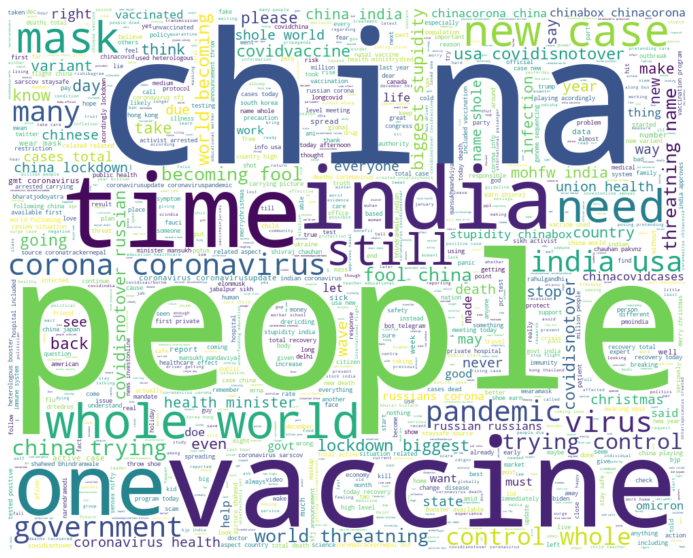

In [132]:
all_list = [tw for tw in df['text']]
all_list = [word for sentence in all_list 
                 for word in sentence.lower().split(" ") 
                 if (word not in ["covid","amp","got"]
                    and len(word) > 2)]

all_words = ' '.join([text for text in all_list])
wordcloud = WordCloud(width=1000, height=800, random_state=20,
                      max_font_size=400, max_words=1000, background_color="white").generate(all_words)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

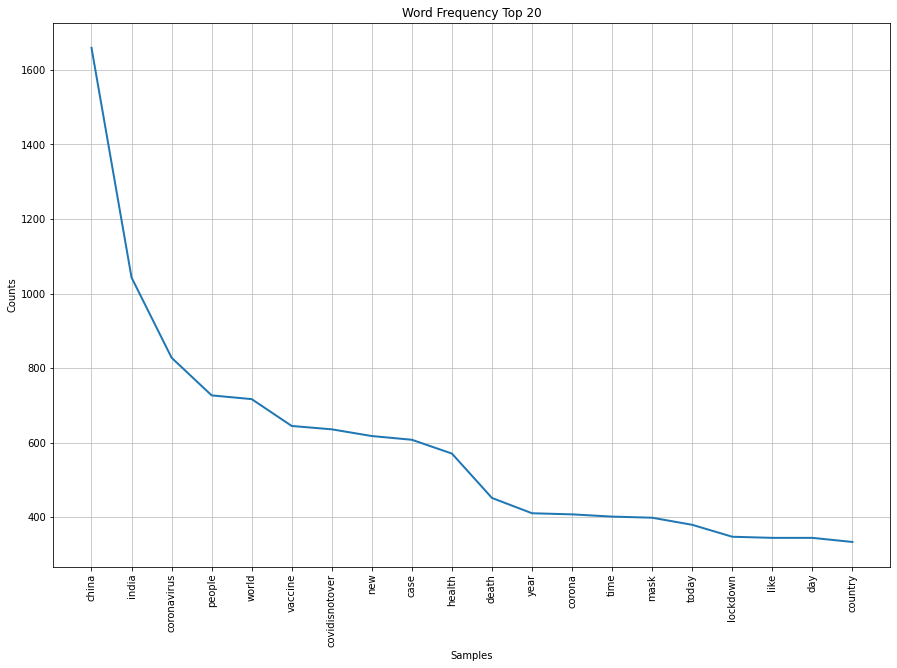

<AxesSubplot:title={'center':'Word Frequency Top 20'}, xlabel='Samples', ylabel='Counts'>

In [133]:
all_freq = FreqDist(all_list)
plt.figure(figsize=(15,10))
all_freq.plot(20, cumulative=False, title="Word Frequency Top 20")

### WordCloud - Negative

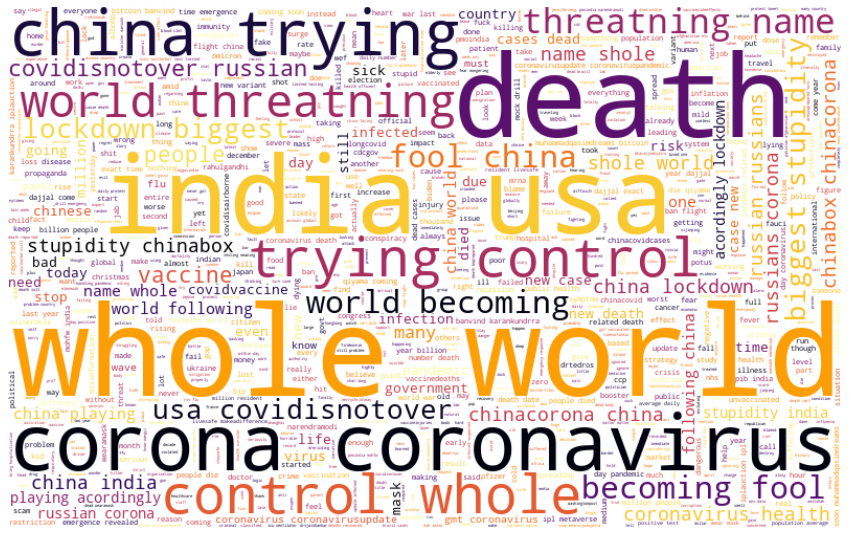

In [134]:
negative_list = [tw for tw in neg_df['text']]

negative_list = [word for sentence in negative_list 
                 for word in sentence.lower().split(" ") 
                 if (word not in ["covid","amp"]
                    and len(word) > 2)]

all_words_neg = ' '.join([text for text in negative_list])
# all_words_neg = all_words_neg.remove("covid")
wordcloud_neg = WordCloud(width=800, height=500, random_state=20, max_font_size=400, max_words=1000,
                         colormap='inferno', background_color="white").generate(all_words_neg)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis('off')
plt.show()

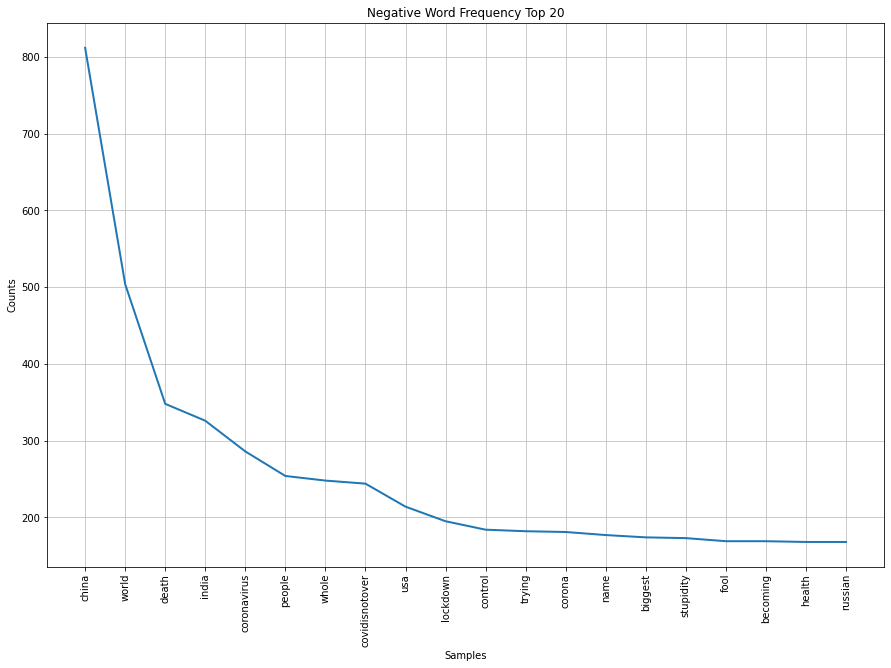

<AxesSubplot:title={'center':'Negative Word Frequency Top 20'}, xlabel='Samples', ylabel='Counts'>

In [168]:
neg_freq = FreqDist(negative_list)
plt.figure(figsize=(15,10))
neg_freq.plot(20, cumulative=False, title="Negative Word Frequency Top 20")

### WordCloud - Positive

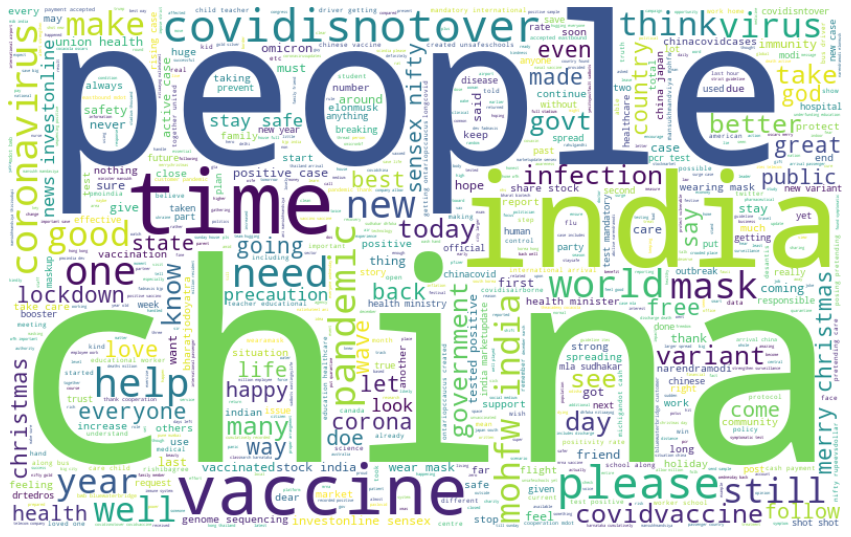

In [136]:
positive_list = [tw for tw in pos_df['text']]

positive_list = [word for sentence in positive_list 
                 for word in sentence.lower().split(" ") 
                 if (word not in ["covid","amp", "t","co"]
                    and len(word) > 2)]

all_words_pos = ' '.join([text for text in positive_list])
# all_words_neg = all_words_neg.remove("covid")
wordcloud_pos = WordCloud(width=800, height=500, random_state=20,
                          max_font_size=400, max_words=1000,
                         background_color='white').generate(all_words_pos)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis('off')
plt.show()

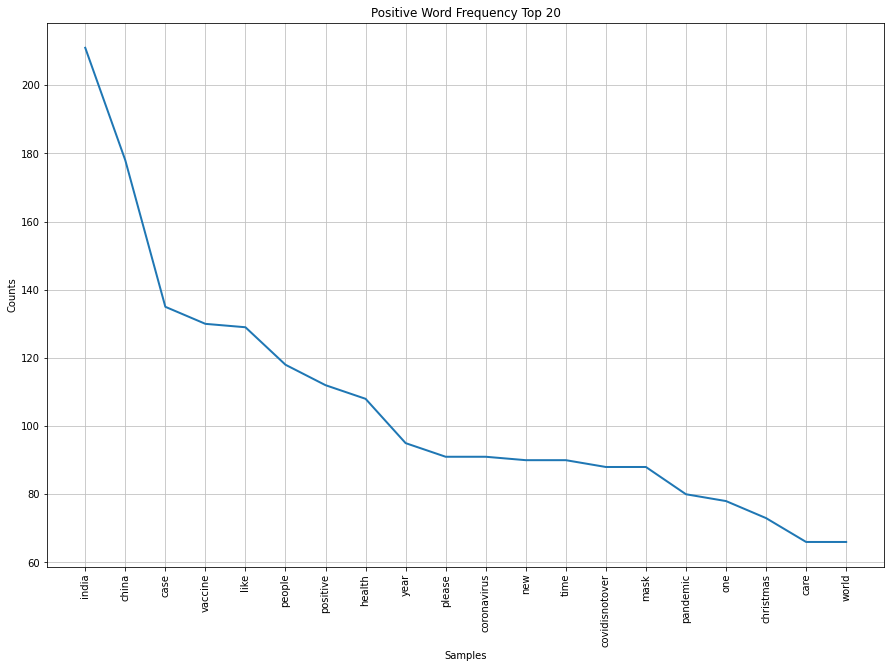

<AxesSubplot:title={'center':'Positive Word Frequency Top 20'}, xlabel='Samples', ylabel='Counts'>

In [167]:
pos_freq = FreqDist(positive_list)
plt.figure(figsize=(15,10))
pos_freq.plot(20, cumulative=False, title="Positive Word Frequency Top 20")

### WordCloud - Neutral

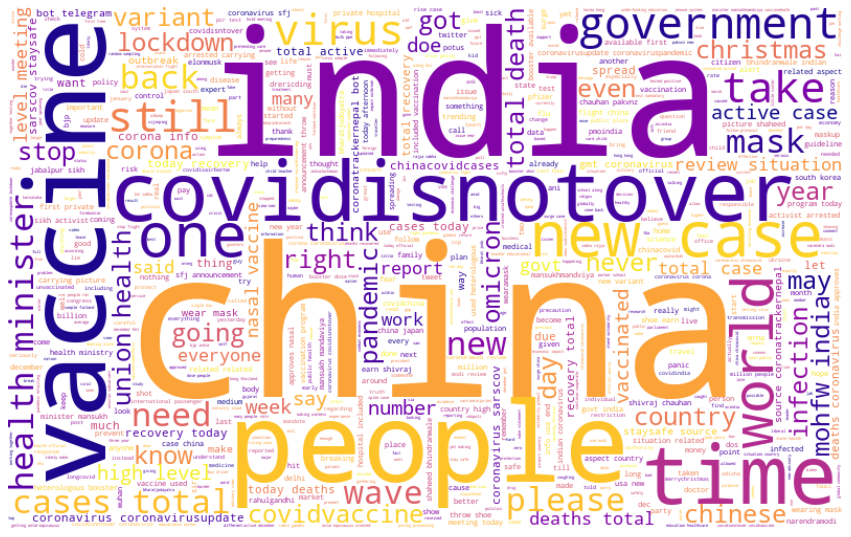

In [138]:
neutral_list = [tw for tw in neut_df['text']]

neutral_list = [word for sentence in neutral_list 
                 for word in sentence.lower().split(" ") 
                 if (word not in ["covid","amp"]
                    and len(word) > 2)]

all_words_neut = ' '.join([text for text in neutral_list])
# all_words_neg = all_words_neg.remove("covid")
wordcloud_neut = WordCloud(width=800, height=500, random_state=20, max_font_size=200,
                          max_words=1000, colormap='plasma', background_color='white').generate(all_words_neut)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_neut, interpolation="bilinear")
plt.axis('off')
plt.show()

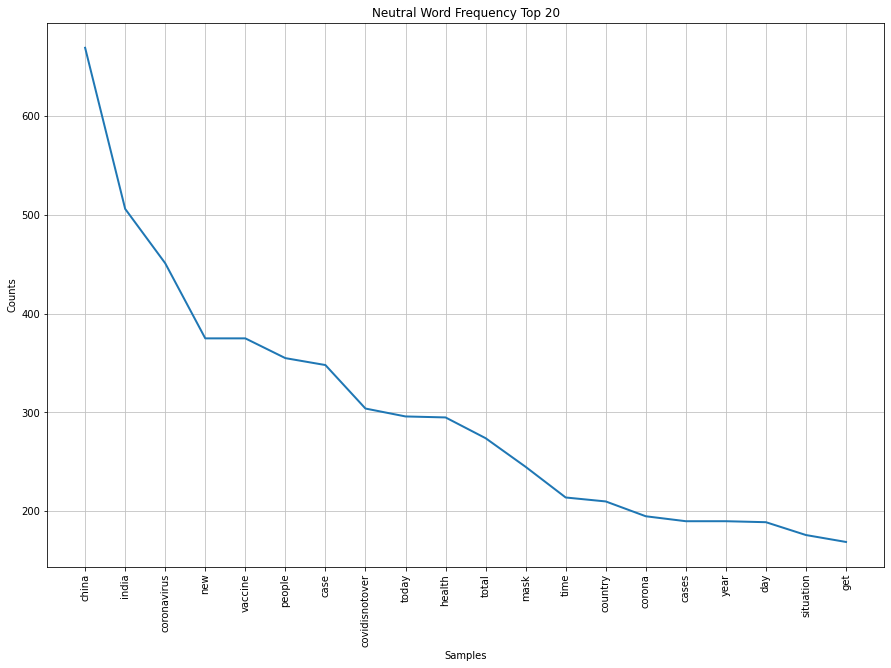

<AxesSubplot:title={'center':'Neutral Word Frequency Top 20'}, xlabel='Samples', ylabel='Counts'>

In [173]:
neut_freq = FreqDist(neutral_list)
plt.figure(figsize=(15,10))
neut_freq.plot(20, cumulative=False, title="Neutral Word Frequency Top 20")

### Calculate Time-Series for Daily Sentiment Score

In [176]:

ts = df.groupby(pd.Grouper(key='timestamp', axis=0, 
                      freq='H', sort=True)).mean()

fig2 = px.line(ts, x=ts.index, y='compound', title='Hourly All Twitter Sentiment Score')
fig2.update_traces(line_color='#456987')
fig2.show()

In [175]:
pos_ts = pos_df.groupby(pd.Grouper(key='timestamp', axis=0, 
                      freq='H', sort=True)).mean()

fig3 = px.line(pos_ts, x=pos_ts.index, y='compound', title='Hourly Positive Twitter Sentiment Score')
fig3.update_traces(line_color='#1FAA19')

fig3.show()

In [174]:
neg_ts = neg_df.groupby(pd.Grouper(key='timestamp', axis=0, 
                      freq='H', sort=True)).mean()

fig4 = px.line(neg_ts, x=neg_ts.index, y='compound', title='Hourly Negative Twitter Sentiment Score')
fig4.update_traces(line_color='#AA1931')
fig4.show()